In [1]:
import sys
import os
#import torch
import zarr
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path
from scipy.stats import linregress, spearmanr
from typing import Union
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from matplotlib.gridspec import GridSpec

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.dataloading import get_monthly_data, prep_ecad, datapath, prep_and_resample, prepare_ecearth_set
from Medley.utils import udomains, regions, tscolnames
from Medley.analysis import trendfit_robust
from Medley.preprocessing import Anomalizer, simultaneous_resample, makemask, average_within_mask, single_target_lagged_resample, multi_target_lagged_resample,remove_bottleneck, make_pipeline
from Medley.crossval import SpatiotemporalSplit
from Medley.visualization import plot_stations, plot_plus_stations
from Medley.interpretation import load_pred_results

/scistor/ivm/jsn295/CAUSALVENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.jpcmciplus import JPCMCIplus

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

In [112]:
anomalize = False
df = get_monthly_data()
if anomalize:
    a = Anomalizer()
    df = a.fit_transform(df)

In [113]:
shift = False
target = prep_ecad(target_region=regions['medwest'], target_var = 'SPI1', shift = shift).to_frame()
target.columns = pd.MultiIndex.from_tuples([('SPI1',0,'ECAD')], names = tscolnames)


In [114]:
expert = True
expid = 'dd0d579f41'
npreds = 10
if expert:
    varnames = [('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250',40,'era5')]
    #varnames = [('amoc',0,'hadisst'),('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250',40,'era5')]
    #varnames = [('enso',34,'ersstv5'),('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250',40,'era5')]
    #varnames = [('enso',34,'ersstv5'),('amoc',0,'hadisst'),('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250',40,'era5')]
    #varnames = [('enso',34,'ersstv5'),('amoc',0,'hadisst'),('nao',0,'station'),('ao',0,'ncep'),('vortex_u20',7080,'era5'),('med_u250_latmax',0,'era5')]
else:
    preds, cv = load_pred_results(expid)
    variables = preds.loc[10,'feature_names']
    varnames = list(set([t[0] for t in variables])) # Through set to get the unique ones (otherwise multiple lags)
    maxlag = abs(min([t[1] for t in variables]))
subset = df.loc[:,varnames].join(target)
subset = subset.dropna(axis = 0, how = 'any')

In [6]:
subset
# potential writing out
#subset.to_csv(f'/scistor/ivm/jsn295/Medi/expert-set_shift-{shift}_season-removed-{anomalize}.csv')

name,nao,ao,vortex_u20,med_u250,SPI1
subindex,0,0,7080,40,0
product,station,ncep,era5,era5,ECAD
1959-01-01,-1.149,-2.0128,20.231567,19.015001,-0.256676
1959-02-01,2.461,2.5445,21.844402,4.211168,-0.590440
1959-03-01,1.818,1.4318,12.184457,15.593440,0.829099
1959-04-01,1.509,0.1192,-5.574272,17.960119,0.212853
1959-05-01,-2.218,-0.3408,-6.392581,14.970626,0.691910
...,...,...,...,...,...
2021-08-01,-2.444,-0.2093,-2.095636,19.822189,-0.362999
2021-09-01,-0.158,-0.2516,4.385739,20.549324,0.057114


#### Seasonal masking (jfm in western med behave similarly)
True if to-be left out

In [179]:
jfmmask = np.tile(~subset.index.month.isin([1,2,3])[:,np.newaxis], (1,subset.shape[-1]))
jfmframe = pp.DataFrame(subset.values, datatime = subset.index,var_names = [f'{v[0]}_{v[1]}' for v in subset.columns],mask = jfmmask)
#jfmframe = pp.DataFrame(subset.values, datatime = subset.index,var_names = [f'{v[0]}' for v in subset.columns],mask = jfmmask)

In [180]:
#tp.plot_timeseries(jfmframe, grey_masked_samples='data'); plt.show()

In [181]:
tau_max = 2
tau_min = 0
pc_alpha = 0.05
alpha_level = 0.003
parcorr = RobustParCorr(significance='analytic',mask_type = 'y')
#parcorr = ParCorr(significance='analytic',mask_type = 'y')
pcmci = PCMCI(
    dataframe=jfmframe, 
    cond_ind_test=parcorr,
    verbosity=1)
results = pcmci.run_pcmci(tau_max=tau_max, tau_min = tau_min, pc_alpha=pc_alpha, alpha_level=alpha_level)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = robust_par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable enso has 1 link(s):
        (enso -1): max_pval = 0.00000, |min_val| =  0.692

    Variable nao has 1 link(s):
        (med_u250 -1): max_pval = 0.00873, |min_val| =  0.192

    Variable ao has 2 link(s):
        (ao -1): max_pval = 0.00096, |min_val| =  0.241
        (med_u250 -1): max_pval = 0.03816, |min_val| =  0.153

    Variable vortex_u20 has 1 link(s):
        (ao -1): max_pval = 0.04597, |min_val| =  0.147

    Variable med_u250 has 3 link(s):
        (ao -1): max_pval = 0.00195, |min_val| =  0.227
        (med_u250 -1): max_pval = 0.01883, |min_val| =  0.173
        (vortex_u20 -1): max_pval = 0.03374, |min_val| =  0.157

    Variable SPI1 has 1 link(s):
        (med_u250 -1): max_pval = 0.01092, |min_val| =  0.187

##
## Step

In [182]:
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=alpha_level, 
            tau_min=tau_min, tau_max=tau_max, link_assumptions=None)
results['graph'] = graph

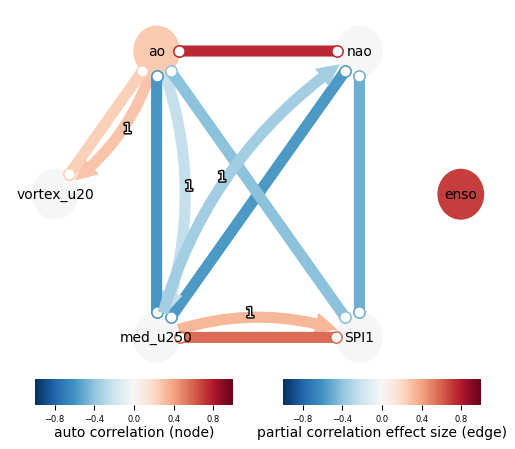

In [183]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=jfmframe.var_names,
    link_colorbar_label='partial correlation effect size (edge)',
    node_colorbar_label='auto correlation (node)',
    show_autodependency_lags=False
    ); plt.show()

### Older stuff

In [114]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=frame, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=12, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 12


In [99]:
np.argmax(np.abs(correlations), axis = 2)

array([[ 1,  7, 22,  2,  3, 31, 28],
       [36,  1, 11, 11, 36,  0, 21],
       [ 7, 13, 28,  0,  0,  0,  0],
       [ 0, 15,  0,  1,  0, 25,  1],
       [ 7, 15,  0,  0,  1,  1,  0],
       [36,  4,  0, 11, 10,  1,  0],
       [10, 32,  0,  0,  0, 29,  1]])

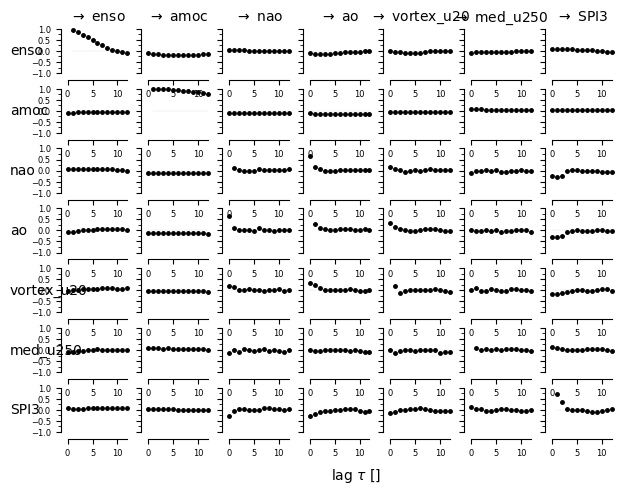

In [115]:
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':frame.var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

## EC-EARTH data
### Influence of AMOC on system behaviour

In [115]:
fake_time = True
anomalize = False
fill_value = 999.
df = prepare_ecearth_set(fake_time_axis=fake_time)

In [116]:
drop_nao = 'ecearth' # Simplification needed for selection based on varnames
subset = df.sort_index(axis = 1).drop(('nao',0,drop_nao), axis = 1)
if fake_time:
    subset.index = subset.index.droplevel('member')
subset.columns = subset.columns.droplevel('product')
subset = subset.stack('amoc')
subset = subset.loc[:,[v[:-1]for v in varnames + [('SPI1',0,'ECAD')]]]
subset.columns = pd.Index([f'{v[0]}' for v in subset.columns])
if anomalize:
    a = Anomalizer()
    subset = a.fit_transform(subset)

In [117]:
# Dictionary for different sets.
ds = {}
masks = {}
datetimes = {}
amoc_strengths = subset.index.get_level_values('amoc').unique()
for i, strength in enumerate(amoc_strengths): # Unfortunately tigramite does not accept the strength strings themselves as keys
    strength_set = subset.loc[(slice(None),strength),:]
    strength_set.index = strength_set.index.droplevel('amoc')
    strength_set.loc[:,'amoc'] = float(strength[:2])
    strength_set = strength_set.reindex(index = pd.date_range(strength_set.index.min(), strength_set.index.max(), freq = 'MS'), fill_value = fill_value)
    jfmmask = np.tile(~strength_set.index.month.isin([1,2,3])[:,np.newaxis], (1,strength_set.shape[-1]))
    masks[i] = jfmmask
    ds[i] = strength_set.values
    datetimes[i] = strength_set.index


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [118]:
nvars = strength_set.shape[-1] # Including the categorical one
node_classification = {}
for i in range(nvars):
    if i != (nvars - 1):
        node_classification[i] = 'system'
    else:
        node_classification[i] = 'space_context'

In [119]:
dataframe = pp.DataFrame(
    data=ds,
    mask=masks,
    analysis_mode = 'multiple',
    missing_flag=fill_value,
    var_names = strength_set.columns,
    datatime = datetimes,
    )

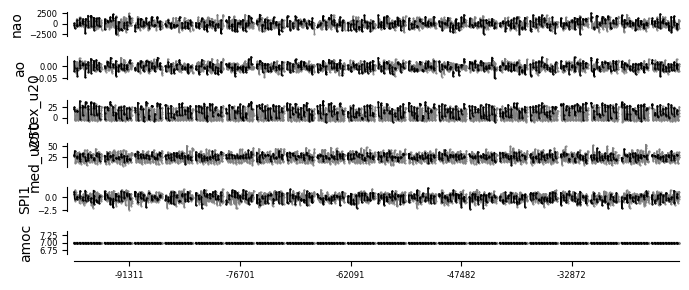

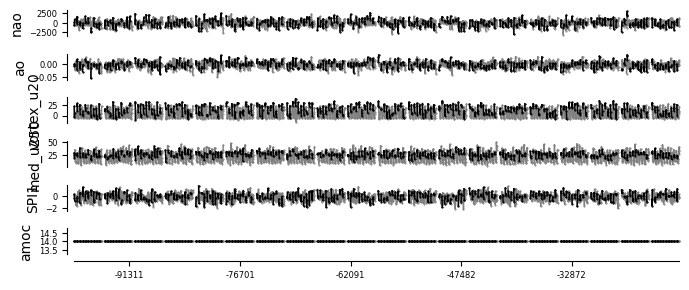

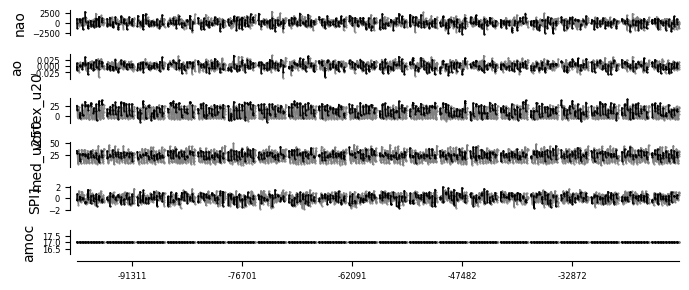

In [120]:
for dataset in [0,1,2]:
    tp.plot_timeseries(selected_dataset = dataset, 
                       dataframe = dataframe, 
                       figsize=(7, 3),
                       grey_masked_samples='data')
    plt.show()

In [124]:
parcorr = RobustParCorr(significance='analytic',mask_type = 'y')
#parcorr = ParCorr(significance='analytic',mask_type = 'y')
tau_max = 2
tau_min = 0
pc_alpha = 0.05
jpcmciplus = JPCMCIplus(dataframe=dataframe,
                          cond_ind_test=parcorr, 
                          node_classification=node_classification,
                          verbosity=1,)
results = jpcmciplus.run_jpcmciplus(tau_max=tau_max, tau_min = tau_min, pc_alpha=pc_alpha)


##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, -1): '-?>', (2, -2): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (5, 0): '-?>'}, 3: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1):

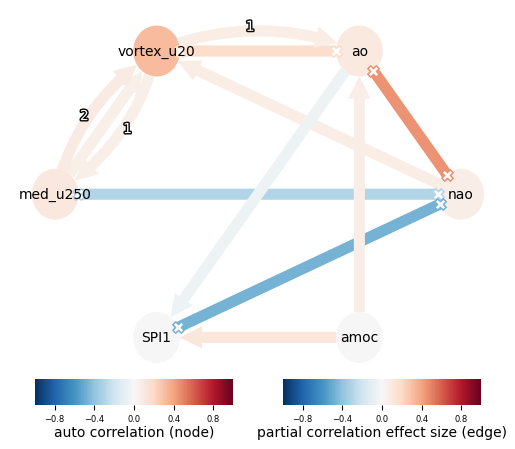

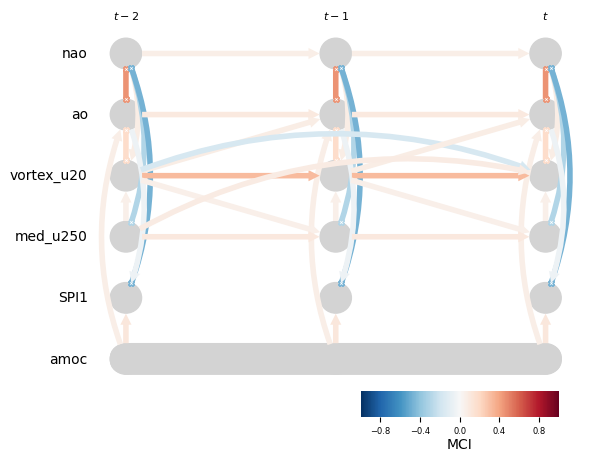

In [125]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=dataframe.var_names,
            link_colorbar_label='partial correlation effect size (edge)',
            node_colorbar_label='auto correlation (node)')
tp.plot_time_series_graph(results['graph'], val_matrix = results['val_matrix'], 
              node_classification = node_classification, var_names=dataframe.var_names)
plt.show()

#### Now per dataset

In [58]:
results = {}
parcorr = RobustParCorr(significance='analytic',mask_type = 'y')
#parcorr = ParCorr(significance='analytic',mask_type = 'y')
tau_max = 2
tau_min = 0
pc_alpha = 0.05
alpha_level = 0.001
for key, strength in enumerate(amoc_strengths):
    print(strength)
    dataframe = pp.DataFrame(
    data=ds[key][:,:-1],
    mask=masks[key][:,:-1],
    analysis_mode = 'single',
    missing_flag=fill_value,
    var_names = strength_set.columns[:-1],
    datatime = datetimes,
    )

    pcmci = PCMCI(dataframe=dataframe,
                                cond_ind_test=parcorr, 
                              verbosity=1,)
    results[strength] = pcmci.run_pcmci(tau_max=tau_max, tau_min = tau_min, pc_alpha=pc_alpha, alpha_level = alpha_level)

07sv

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = robust_par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable nao has 2 link(s):
        (vortex_u20 -1): max_pval = 0.00002, |min_val| =  0.177
        (nao -1): max_pval = 0.02964, |min_val| =  0.091

    Variable ao has 3 link(s):
        (vortex_u20 -1): max_pval = 0.00000, |min_val| =  0.267
        (nao -1): max_pval = 0.01151, |min_val| =  0.105
        (med_u250 -2): max_pval = 0.04285, |min_val| =  0.086

    Variable vortex_u20 has 3 link(s):
        (vortex_u20 -1): max_pval = 0.00000, |min_val| =  0.387
        (vortex_u20 -2): max_pval = 0.00000, |min_val| =  0.207
        (med_u250 -1): max_pval = 0.00424, |min_val| =  0.119

    Variable med_u250 has 2 link(s):
        (vortex_u20 -1): max_pval = 0.00006, |min_val| =  0.166
        (med_u250 -1): max_pval = 0.00053, |min_val| =

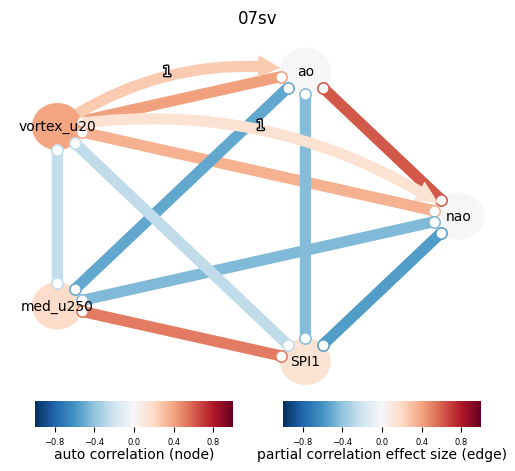

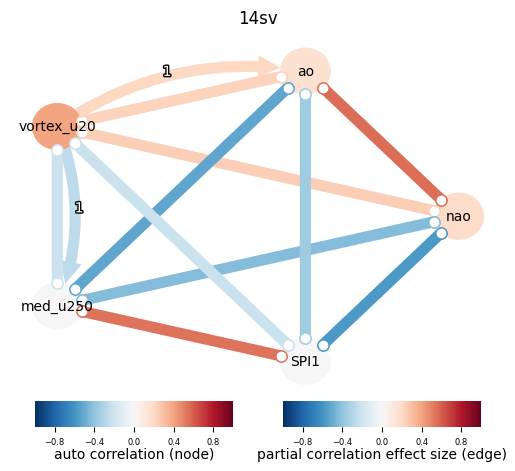

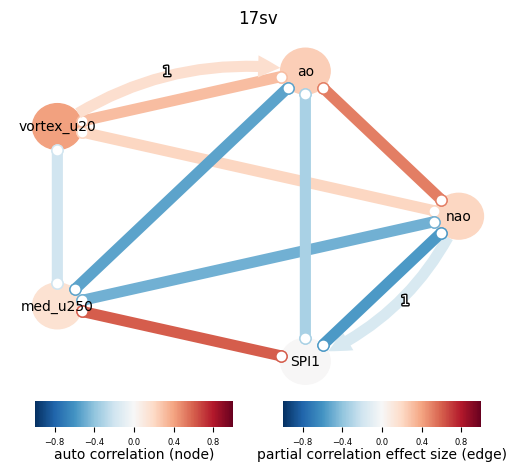

In [60]:
for strength in amoc_strengths:
    tp.plot_graph(results[strength]['graph'], val_matrix=results[strength]['val_matrix'], var_names=strength_set.columns[:-1],
                link_colorbar_label='partial correlation effect size (edge)',
                node_colorbar_label='auto correlation (node)')
    plt.title(strength)
    plt.show()

### Influence on AMOC on the system variables

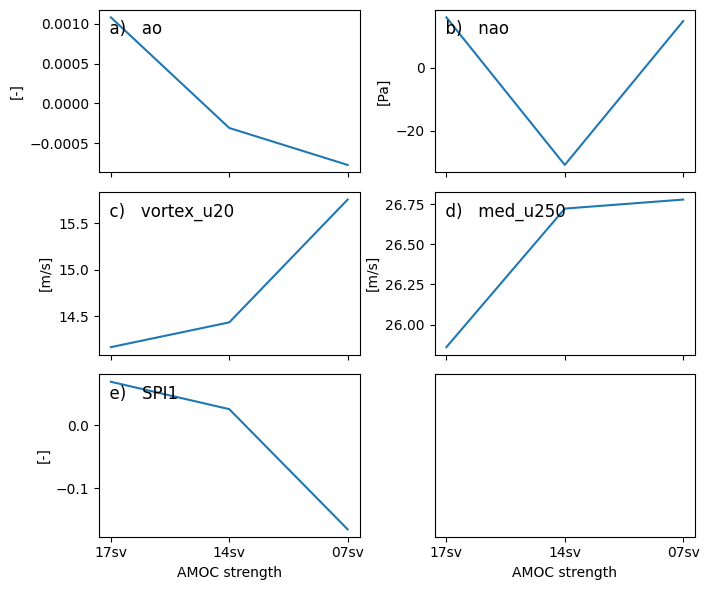

In [132]:
# Means accross time and members:
# ONly in winter
months = [1,2,3]
plotdf = subset.unstack('amoc')
means = plotdf.loc[plotdf.index.get_level_values('time').month.isin(months),:].mean(axis = 0).unstack(0).sort_index(ascending = False)
means = means.reindex(['ao','nao','vortex_u20','med_u250','SPI1'], axis = 1)
units = pd.Series(['-','Pa','m/s','m/s','-'], index = means.columns)
fig, axes = plt.subplots(nrows = 3, ncols = 2, sharex = True, figsize = (7,6))
for i, name in enumerate(means.columns):
    ax = axes[i//2, i%2]
    ax.plot(means.index, means[name])
    #means.loc[:,name].plot()
    ax.set_title(f'  {"abcde"[i]})   {name}', y = 0.8, loc = 'left')
    ax.set_ylabel(f'[{units[name]}]')
axes[-1,0].set_xlabel('AMOC strength')
axes[-1,1].set_xlabel('AMOC strength')
axes[-1,1].set_yticks([])
plt.tight_layout()
plt.show()

,ao,nao,vortex_u20,med_u250,SPI1
amoc,,,,,
17sv,0.001083,16.151432,14.171226,25.859222,0.068677
14sv,-0.000309,-30.971758,14.436853,26.722284,0.025201
07sv,-0.000774,14.963216,15.753262,26.778404,-0.165555


In [ ]:
ax.se

In [70]:
means

,nao,ao,vortex_u20,med_u250,SPI1
amoc,,,,,
17sv,16.151432,0.001083,14.171226,12.976648,0.068677
14sv,-30.971758,-0.000309,14.436853,14.046790,0.025201
07sv,14.963216,-0.000774,15.753262,14.917331,-0.165555
